**Importing Required Libraries**

In [1]:
!pip install -q transformers
!pip install -q --pre pycaret

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from transformers import AdamW
from transformers import RobertaForSequenceClassification,RobertaTokenizer
from transformers import RobertaTokenizerFast,RobertaForMaskedLM,RobertaModel
from transformers import DebertaTokenizer, DebertaModel,DebertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoConfig
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Loading and Data Visualization**

In [60]:
#paths="/content/sample_data/"
paths="/kaggle/input/explainable-detection-of-online-sexism/"
df = pd.read_csv(paths+'train_all_tasks.csv')
dfval = pd.read_csv(paths+'dev_task_c_entries.csv')
dfval_labels = pd.read_csv(paths+'dev_task_c_labels.csv')
dftest = pd.read_csv(paths+'test_task_c_entries.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
dtypes: object(5)
memory usage: 547.0+ KB
None


In [61]:
print(dftest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  970 non-null    object
 1   text       970 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB
None


**Removed Unused Parameter**

In [62]:
#print(df.info)
df_filtered = df[df['label_sexist'] == "sexist"]
df_filtered.drop(['rewire_id','label_sexist','label_category'], axis=1, inplace=True)
df=df_filtered
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3398 entries, 8 to 13995
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          3398 non-null   object
 1   label_vector  3398 non-null   object
dtypes: object(2)
memory usage: 79.6+ KB
None


In [63]:
print(df.describe())

                                                     text  \
count                                                3398   
unique                                               3398   
top     just the inside of your wallet: cash, bank car...   
freq                                                    1   

                   label_vector  
count                      3398  
unique                       11  
top     2.1 descriptive attacks  
freq                        717  


In [64]:
freq=df['label_vector'].value_counts().to_dict()
print(freq)

{'2.1 descriptive attacks': 717, '2.2 aggressive and emotive attacks': 673, '3.1 casual use of gendered slurs, profanities, and insults': 637, '3.2 immutable gender differences and gender stereotypes': 417, '4.2 supporting systemic discrimination against women as a group': 258, '1.2 incitement and encouragement of harm': 254, '2.3 dehumanising attacks & overt sexual objectification': 200, '4.1 supporting mistreatment of individual women': 75, '3.3 backhanded gendered compliments': 64, '1.1 threats of harm': 56, '3.4 condescending explanations or unwelcome advice': 47}


**Distibution of sexist and non sexist text labels**

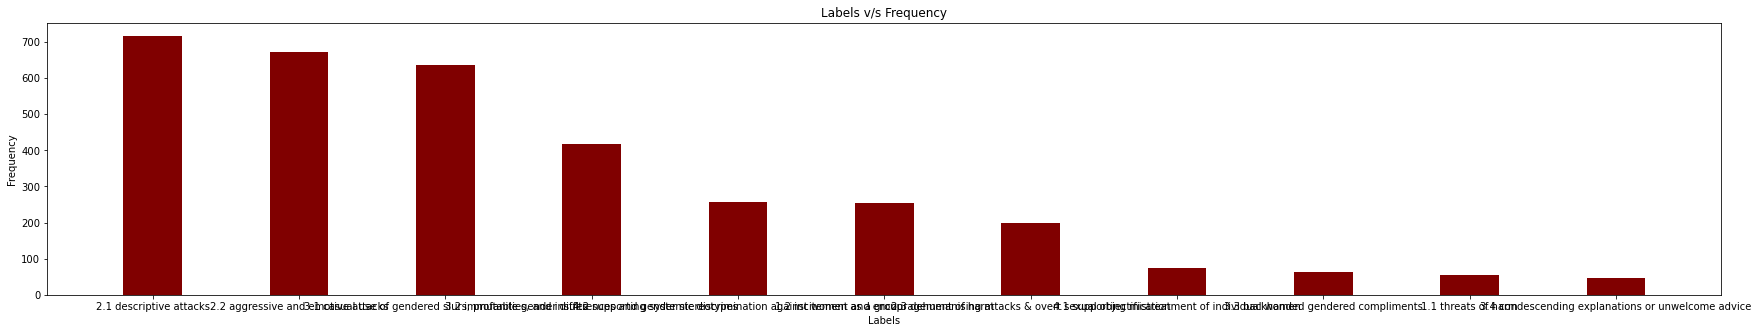

In [65]:
data = freq
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (30, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.show()

**Dataset to Lists**

In [66]:
trainTexts=df['text'].tolist()
trainLabels=df['label_vector'].tolist()

valTexts=dfval['text']
valLabels=dfval_labels['label'].tolist()

testTexts=dftest['text']

In [67]:
print(len(trainTexts),len(trainLabels))
print(len(valTexts),len(valLabels))
print(len(testTexts))

3398 3398
486 486
970


**Distibution of Numbers of words in each text**

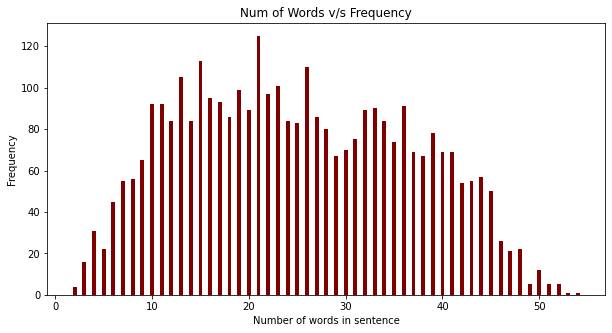

In [68]:
freq={}
for sentence in trainTexts:
    num_text=len(sentence.split())
    if num_text not in freq:
        freq[num_text]=0
    freq[num_text]+=1

types = list(freq.keys())
frequency = list(freq.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Number of words in sentence")
plt.ylabel("Frequency")
plt.title("Num of Words v/s Frequency")
plt.show()

**Data Cleaning Modul** But not used

In [69]:
class DataCleaning():
    """
        Take a list of strings and preprocess strings, it preforms:
        
    """
    def __init__(self, list_data):
        self.data = list_data
        self.len = len(list_data)

    def clean_data(self):
        self.emojis_to_text()
        self.lowerCase()
        self.linkToTag()
        self.removePunctuations()
        self.removeWordsWithNumber()
        
    def tokenizer():
        pass
        
    def rootWord(self,lemmatizer=False):
        """
            Steamer is faster than lammatization.
            Steamer cut the last few words, and use the root word
            lemmatizer convert many form a word to the same word. 
            stemmer will retun 'car' for word 'caring'
            while lemmatizer return 'care' for 'caring'
        """
        if not lemmatizer:
            stemmer = PorterStemmer()
            for i in range(self.len):
                self.data[i]=" ".join([stemmer.stem(word) for word in self.data[i].split()])
        else:
            lemmatizer = WordNetLemmatizer()
            for i in range(self.len):
                self.data[i]=" ".join([lemmatizer.lemmatize(word) for word in self.data[i].split()])
        
    def removePunctuations(self):
        removePunc = re.compile(r'[^\w\s]')
        for i in range(self.len):
            self.data[i] = re.sub(removePunc, r" ",self.data[i])

    def emojis_to_text(self):
        """
            Converting image to its text meaning.
            Format: 👍 to ":thumbs_up:"
        """
        for i in range(self.len):
            self.data[i]=emoji.demojize(self.data[i])
            
    def linkToTag(self):
        """replacing web links with '<URL>'"""
        linkRegex = re.compile(r'\b(www|http|https)[^ |\n]*')

        for i in range(self.len):
            self.data[i] = re.sub(linkRegex, r"<URL>",self.data[i])
    
    def removeWordsWithNumber(self):
        """
            Zero or more number of non-whitespace then digit, 
            then Zero or more number of non-whitespace
        """
        wordNumRegex = re.compile(r'\S*\d\S*')
        for i in range(self.len):
            self.data[i]=re.sub(wordNumRegex,r"",self.data[i])
    
    def lowerCase(self):
        """
            It is sometimes important to keep the letter capital 
            as it signifies shouting in form of that word, but it
            depends on use case
        """
        for i in range(self.len):
            self.data[i]=self.data[i].lower()
            
    def removeStopword(self):
        """ Remove stopward from a string"""
        stop = stopwords.words('english')
        for i in range(self.len):
            self.data[i]=' '.join([word for word in self.data[i].split() if word not in stop])

In [70]:
#cleaning=DataCleaning(texts)
#cleaning.clean_data()
#texts=cleaning.data

**Loading Model**

In [71]:
# RoBERTa

preTrainedModel=True
roberta=""
roberta_tokenizer=""

if preTrainedModel == False:
    print('Loading Base model')
    roberta = RobertaModel.from_pretrained("roberta-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
    deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', use_fast=True, do_lower_case=False, max_len=64)
    deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
    
else:
    print("Loading Domain Adaptive Pretrained Model")
    modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt"
    roberta_tokenizer = RobertaTokenizer.from_pretrained(modelpath, use_fast = False, do_lower_case=True)
    roberta = RobertaModel.from_pretrained(modelpath)
    print("\n")
    
    deberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta"
    deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_modelpath, use_fast = False, do_lower_case=True)
    deberta = DebertaModel.from_pretrained(deberta_modelpath)
    
    

Loading Domain Adaptive Pretrained Model


Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt and are newly initialized: ['roberta.pooler.dense

Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta were not used when initializing DebertaModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Converting Train Data to Appropriate format**

In [72]:
MAX_LENGHT = 64
batch_size = 64

In [73]:
# print(len(trainTexts),len(trainLabels))
# print(len(valTexts),len(valLabels))
# print(len(testTexts))

In [74]:
#will encode list of text

tokens_train_roberta = roberta_tokenizer.batch_encode_plus(trainTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
tokens_train_deberta = deberta_tokenizer.batch_encode_plus(trainTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)

tokens_val_roberta = roberta_tokenizer.batch_encode_plus(valTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
tokens_val_deberta = deberta_tokenizer.batch_encode_plus(valTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)

tokens_test_roberta = roberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
tokens_test_deberta = deberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)

In [75]:
# Train
train_seq_roberta = torch.tensor(tokens_train_roberta['input_ids'],device=device)
train_mask_roberta = torch.tensor(tokens_train_roberta['attention_mask'],device=device)

train_seq_deberta = torch.tensor(tokens_train_deberta['input_ids'],device=device)
train_mask_deberta = torch.tensor(tokens_train_deberta['attention_mask'],device=device)

# Validation
val_seq_roberta = torch.tensor(tokens_val_roberta['input_ids'],device=device)
val_mask_roberta = torch.tensor(tokens_val_roberta['attention_mask'],device=device)

val_seq_deberta = torch.tensor(tokens_val_deberta['input_ids'],device=device)
val_mask_deberta = torch.tensor(tokens_val_deberta['attention_mask'],device=device)

# Test
test_seq_roberta = torch.tensor(tokens_test_roberta['input_ids'],device=device)
test_mask_roberta = torch.tensor(tokens_test_roberta['attention_mask'],device=device)

test_seq_deberta = torch.tensor(tokens_test_deberta['input_ids'],device=device)
test_mask_deberta = torch.tensor(tokens_test_deberta['attention_mask'],device=device)


In [78]:

ytrain=[]
yval=[]

LABELS=[trainLabels,valLabels]

for task in LABELS:
    for label in task:
        if label=="1.1 threats of harm":
            ytrain.append(0)
        elif label=="1.2 incitement and encouragement of harm":
            ytrain.append(1)
        elif label=="2.1 descriptive attacks":
            ytrain.append(2)
        elif label=="2.2 aggressive and emotive attacks":
            ytrain.append(3)
        elif label=="2.3 dehumanising attacks & overt sexual objectification":
            ytrain.append(4)
        elif label=="3.1 casual use of gendered slurs, profanities, and insults":
            ytrain.append(5)
        elif label=="3.2 immutable gender differences and gender stereotypes":
            ytrain.append(6)
        elif label=="3.3 backhanded gendered compliments":
            ytrain.append(7)
        elif label=="3.4 condescending explanations or unwelcome advice":
            ytrain.append(8)
        elif label=="4.1 supporting mistreatment of individual women":
            ytrain.append(9)
        else: #4.2 supporting systemic discrimination against women as a group
            ytrain.append(10)
        
yval=ytrain[len(trainLabels):]
ytrain=ytrain[:len(trainLabels)]
        
train_y = torch.tensor(ytrain,device=device)
val_y=torch.tensor(yval,device=device)

In [79]:
print(len(yval),len(ytrain))

486 3398


In [80]:
print(len(train_seq_roberta),len(train_mask_roberta),len(train_y))
print(len(val_seq_roberta),len(val_mask_roberta),len(val_y))
print(len(test_seq_roberta),len(test_mask_roberta))

3398 3398 3398
486 486 486
970 970


In [81]:
train_data = TensorDataset(train_seq_roberta, train_mask_roberta,train_seq_deberta, train_mask_deberta, train_y)
train_sampler = RandomSampler(train_data)                    
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)                                                            

In [82]:
val_data = TensorDataset(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta, val_y)                        
val_dataloader = DataLoader(val_data, batch_size=batch_size) 

In [83]:
for param in roberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed
    
for param in deberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed

**Model**

In [84]:
class RoBERT_Arch(nn.Module):
    def __init__(self, roberta,deberta):  
        super(RoBERT_Arch, self).__init__()
        self.roberta = roberta
        self.deberta = deberta
        self.dropout = nn.Dropout(0.1)            
        self.relu =  nn.ReLU()                    
        
        self.fc0 = nn.Linear(768*2,1024)
        self.fc1 = nn.Linear(1024,512)            
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,11)  
        
        self.softmax = nn.LogSoftmax(dim=1)       
    
    def forward(self, sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta):            
        cls_hs1 = self.roberta(sent_id_roberta, attention_mask=mask_roberta)
        cls_hs2 = self.deberta(sent_id_deberta, attention_mask=mask_deberta)
        
        hidden_state1 = cls_hs1[0]
        cls_hs1 = hidden_state1[:, 0]
        
        hidden_state2 = cls_hs2[0]
        cls_hs2 = hidden_state2[:, 0]
        
        x=torch.cat((cls_hs1,cls_hs2),1)
        
        x = self.fc0(x)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x) #Activation function,followed by dropout , in case of relu it is same
        x = self.dropout(x)
        x = self.fc2(x)    
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)      
        return x

model = RoBERT_Arch(roberta,deberta)
#model= nn.DataParallel(model)
model = model.to(device)

**Hyperparameter**

In [94]:
optimizer = AdamW(model.parameters(),lr = 1e-5)         
cross_entropy  = nn.NLLLoss() 
epochs = 12

**Training**

In [95]:
def train(train_dataloader,val_dataloader,val_y,useFullData=False):  
    """
        Go through the dataloader and back propogated the error
    """
    model.train()
    total_loss=0
    val_preds=[]
    dataloader=[train_dataloader]
    
    if useFullData:
        dataloader.append(val_dataloader)

    for loader in dataloader:
        for step,batch in enumerate(tqdm(loader,position=0, leave=True)):          
            batch = [r for r in batch]                                  
            sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta, labels = batch 
            model.zero_grad()                                          
            preds = model(sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta).to(device)           
                                
            loss = cross_entropy(preds, labels)   
        
            loss.backward()                                             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
            optimizer.step()    
            total_loss = total_loss + loss.item()     
     
        #trainf1=f1_score(train_preds,labels.detach().cpu(),average="macro")
    
    with torch.no_grad():
  
        for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
            
            batch = [r for r in batch]                                  
            sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta, labels = batch 
            
            preds = model(sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta).to(device)           
            preds = torch.argmax(preds,dim=1)
            val_preds+=preds.tolist()                         
    
        valf1=f1_score(val_preds,val_y.detach().cpu(),average="macro")

    return total_loss,valf1

In [96]:
def Inference(test_seq_roberta, test_mask_roberta,test_seq_deberta, test_mask_deberta,dfT):
    """
        No backpropogation. Better way to do this, is with dataloader
    """
    
    with torch.no_grad():
        preds = model(test_seq_roberta, test_mask_roberta,test_seq_deberta, test_mask_deberta)
        preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis = 1)
    
    label_pred=[]

    # edit this part for different number of labels
    for label in preds:
        if label == 0:
            label_pred.append('1.1 threats of harm')
        elif label == 1:
            label_pred.append('1.2 incitement and encouragement of harm')
        elif label == 2:
            label_pred.append('2.1 descriptive attacks')
        elif label == 3:
            label_pred.append('2.2 aggressive and emotive attacks')
        elif label == 4:
            label_pred.append('2.3 dehumanising attacks & overt sexual objectification')
        elif label == 5:
            label_pred.append('3.1 casual use of gendered slurs, profanities, and insults')
        elif label == 6:
            label_pred.append('3.2 immutable gender differences and gender stereotypes')
        elif label == 7:
            label_pred.append('3.3 backhanded gendered compliments')
        elif label == 8:
            label_pred.append('3.4 condescending explanations or unwelcome advice')
        elif label == 9:
            label_pred.append('4.1 supporting mistreatment of individual women')
        else:
            label_pred.append('4.2 supporting systemic discrimination against women as a group')
    
    if 'text' in dfT:
        dfT.drop(['text'], axis=1, inplace=True)
    dfT["label_pred"]=label_pred
    dfT.to_csv('prediction.csv', index=False)

**Training Loop**

In [97]:
counter=0

losses=[]
f1=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    total_loss,valf1 = train(train_dataloader,val_dataloader,val_y,True)            
    print('Training Loss: ',total_loss)
    print('F1 accuracy: ',valf1)
    torch.save(model.state_dict(), 'Baseline+DPT+de+ro+'+str(counter)+".pt")
    counter+=1


 Epoch 1 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  66.38465470075607
F1 accuracy:  0.3061415420509651

 Epoch 2 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  60.23385888338089
F1 accuracy:  0.34659598289917876

 Epoch 3 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  55.375249445438385
F1 accuracy:  0.37850488424839646

 Epoch 4 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  50.650888562202454
F1 accuracy:  0.4062100064140525

 Epoch 5 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  46.86324651539326
F1 accuracy:  0.4164524969623015

 Epoch 6 / 12


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Training Loss:  43.71538892388344
F1 accuracy:  0.4438925094042556

 Epoch 7 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  40.29773807525635
F1 accuracy:  0.45221764137413795

 Epoch 8 / 12


100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


Training Loss:  36.63213808834553
F1 accuracy:  0.4842080469542703

 Epoch 9 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  32.55599322915077
F1 accuracy:  0.4686721928531517

 Epoch 10 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  29.712955579161644
F1 accuracy:  0.5619409339962003

 Epoch 11 / 12


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Training Loss:  26.568264976143837
F1 accuracy:  0.6351948184203795

 Epoch 12 / 12


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Training Loss:  24.22049467265606
F1 accuracy:  0.6210604562123506


In [98]:
path = "/kaggle/working/Baseline+DPT+de+ro+11.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Inference for Test Data**

In [99]:
#Inference(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta,dfval)
Inference(test_seq_roberta, test_mask_roberta,test_seq_deberta, test_mask_deberta,dftest)

**Silver Labelling**: This part has not been implemented due to time constraints

In [30]:
dtf_mlm1 = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/gab_1M_unlabelled.csv')
dtf_mlm2 = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/reddit_1M_unlabelled.csv')
dtf_mlm=dtf_mlm1.append(dtf_mlm2)
print(dtf_mlm)
MAX_LENGHT = 64

silvertestdata=dtf_mlm["text"].tolist()[:300000]

tokens_silver_roberta = roberta_tokenizer.batch_encode_plus(
    silvertestdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
print("roberta tokenizer done")
tokens_silver_deberta = deberta_tokenizer.batch_encode_plus(
    silvertestdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

print("deberta tokenizer done")

# Convert lists to tensors
silver_seq_roberta = torch.tensor(tokens_silver_roberta['input_ids'],device=device)
silver_mask_roberta = torch.tensor(tokens_silver_roberta['attention_mask'],device=device)

silver_seq_deberta = torch.tensor(tokens_silver_deberta['input_ids'],device=device)
silver_mask_deberta = torch.tensor(tokens_silver_deberta['attention_mask'],device=device)

silver_data = TensorDataset(silver_seq_roberta, silver_mask_roberta,silver_seq_deberta, silver_mask_deberta)

                                                     text
0                       JUST SAYING.... YOU LOSE BIATCHES
1       HOW WOULD I DESCRIBE BERKELEY RIOTS? 1) Charmi...
2       Or maybe a little south of Herring Run. More l...
3                                      That's funny...but
4       Unbelievable! It Was (((Rosenstein))) Who Hid ...
...                                                   ...
999995  And the men and women successfully using it wo...
999996  By taking advantage of betas. Good one. I gues...
999997  You're clearly a fakecel if having a daughter ...
999998  No. Suicide takes shortsightedness, blindness....
999999  Quora has some retarded ass shit on it. I read...

[2000000 rows x 1 columns]
roberta tokenizer done
deberta tokenizer done


In [31]:
silver_dataloader = DataLoader(silver_data, batch_size=64)

In [32]:
with torch.no_grad():
    c=0
    index=0
    dataset_text=[]
    dataset_label=[]
    
    for step,batch in enumerate(tqdm(silver_dataloader,position=0, leave=True)):          
        batch = [r for r in batch]                                  
        sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta = batch         
        preds = model(sent_id_roberta, mask_roberta, sent_id_deberta,mask_deberta).to(device)
        
        preds = preds.detach().cpu().numpy()
        
        for value in preds:
            if value[0]>value[1]:
                dataset_text.append(dtf_mlm["text"][index])
                dataset_label.append("not sexist")
            else:
                dataset_text.append(dtf_mlm["text"][index])
                dataset_label.append("sexist")
                
            index+=1
            

  1%|          | 27/4688 [00:10<31:20,  2.48it/s]


KeyboardInterrupt: 

In [ ]:
df_silver = pd.DataFrame(
    dict(
        text=dataset_text,
        label_sexist=dataset_label
    )
)  
    
df_silver.to_csv('silver_labels.csv', index=False)